<a href="https://colab.research.google.com/github/Wanita-8943/Project_2023/blob/main/1_1e-4_16_0.2_Male18_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [49]:
import pandas as pd
import shutil

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [51]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [52]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [53]:
batch_size = 16
width = 150
height = 150
epochs = 50
NUM_TRAIN = 1425
NUM_TEST = 475
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [54]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


In [55]:
import keras

In [56]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [57]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [58]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [59]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(19, activation='softmax', name="fc_out"))
model.add(layers.Dense(1))

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
 dense_2 (Dense)             (None, 1)                 20        
                                                                 
Total params: 4,073,923
Trainable params: 4,031,907
Non-trainable params: 42,016
_______________________________________

In [61]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 215
This is the number of trainable layers after freezing the conv base: 4


In [62]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_130 (Conv2D)            (None, 75, 75, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_98 (BatchN  (None, 75, 75, 32)  128         ['conv2d_130[0][0]']             
 ormalization)                                                                                    
                                                                                    

#สร้างโฟลเดอร์ Train Valodation และ Test

In [63]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_Data_Male125.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07M,0,VV03.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
1,2,1,7,Y07M,0,Flip_VV03.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
2,3,2,7,Y07M,0,VV04.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
3,4,2,7,Y07M,0,Flip_VV04.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
4,5,3,7,Y07M,0,VV05.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
...,...,...,...,...,...,...,...,...,...
2370,121,77,25,Y25M,18,Flip_J463.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2371,122,78,25,Y25M,18,J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2372,123,78,25,Y25M,18,Flip_J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2373,124,79,25,Y25M,18,J465.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both


In [64]:
train = df[df['Fig_Age'].between(1,75)]
val = df[df['Fig_Age'].between(76,100)]

In [65]:
DATA_PATH = "/content/drive/My Drive/TVT_Male125"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/TVT_Male125/train
/content/drive/My Drive/TVT_Male125/validation



#Train

In [66]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [67]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_filename',
        y_col = 'Class_Re',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'Path_filename',
        y_col = 'Class_Re',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

Found 1425 validated image filenames.
Found 475 validated image filenames.


In [73]:
model.compile(loss='mse',
          optimizer=Adam(learning_rate=1e-2),
          metrics=['mae'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-73-dbe5250147b4>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
89/89 [==============================] - 33s 279ms/step - loss: 75.4626 - mae: 7.1433 - val_loss: 65.3380 - val_mae: 6.6155
Epoch 2/50
89/89 [==============================] - 25s 271ms/step - loss: 56.7353 - mae: 6.1446 - val_loss: 49.6124 - val_mae: 5.7755
Epoch 3/50
89/89 [==============================] - 26s 284ms/step - loss: 45.0237 - mae: 5.5444 - val_loss: 40.9631 - val_mae: 5.3399
Epoch 4/50
89/89 [==============================] - 20s 220ms/step - loss: 37.6574 - mae: 5.1527 - val_loss: 35.3378 - val_mae: 5.0205
Epoch 5/50
89/89 [==============================] - 22s 230ms/step - loss: 33.4728 - mae: 4.9245 - val_loss: 32.5123 - val_mae: 4.8951
Epoch 6/50
89/89 [==============================] - 25s 272ms/step - loss: 31.5172 - mae: 4.8264 - val_loss: 30.9593 - val_mae: 4.7885
Epoch 7/50
89/89 [==============================] - 26s 287ms/step - loss: 30.6726 - mae: 4.7817 - val_loss: 30.4612 - val_mae: 4.7677
Epoch 8/50
89/89 [==============================] - 27s

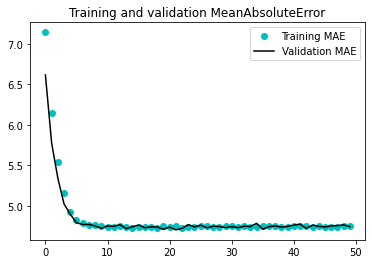

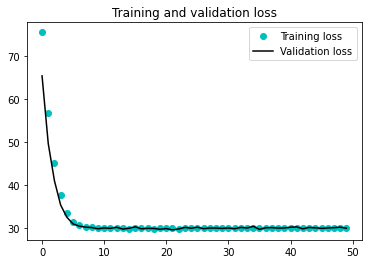

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']


epochs_x = range(len(loss))


plt.plot(epochs_x, mae, 'co', label='Training MAE')
plt.plot(epochs_x, val_mae, 'k', label='Validation MAE')
plt.title('Training and validation MeanAbsoluteError')
plt.legend()

plt.figure()
plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [70]:
epochs_x

range(0, 50)

#Download the model


In [75]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/1e-2_16_0.2_Male18_50.h5')

In [72]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/1.1_รอบแรก_Flimpano_Male125_250.h5')